Cell 1: Imports & GPU Check

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# --- CONFIGURATION ---
# UPDATE THIS PATH to your dataset folder
DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"

IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
SEED = 42

# Global dictionary to store results
results = {}
predictions_storage = {} # To store predictions for graphs

# --- DEVICE SETUP (CUDA) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: GPU not detected.")

Using Device: cuda
GPU Name: NVIDIA GeForce GTX 1050 Ti


Cell 2: Dataset Class & Model Definition

In [4]:
# 1. Custom Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((128, 128, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# 2. Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        # 128 channels * 16 * 16 (after 3 pooling layers of 128x128)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2) # Output: 2 classes (Healthy vs Glaucoma)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. Training Engine
def train_and_evaluate(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {acc*100:.2f}%")

    # Store results for plotting
    results[model_name] = acc
    predictions_storage[model_name] = (y_true, y_pred)

    return acc

Cell 3: Stage 1 - Basic CNN (No Augmentation)

In [5]:
print("--- STAGE 1: BASIC CNN (Baseline) ---")

# Basic Transforms
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Data
full_dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)

# Split indices manually to keep track
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(SEED)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Loaders
train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Train
model_basic = SimpleCNN()
acc_basic = train_and_evaluate(model_basic, train_loader, test_loader, EPOCHS, "1. Basic CNN")

--- STAGE 1: BASIC CNN (Baseline) ---

--- Training 1. Basic CNN ---
1. Basic CNN Accuracy: 91.95%


Cell 4: Stage 2 - CNN with Data Augmentation

In [7]:
print("--- STAGE 2: AUGMENTED CNN ---")

# Augmented Transforms
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# We need a new dataset object with the augmented transforms
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

# Use the SAME indices as Stage 1 to ensure a fair comparison
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

# Train
model_aug = SimpleCNN()
acc_aug = train_and_evaluate(model_aug, train_loader_aug, test_loader_aug, EPOCHS, "2. Augmented CNN")

--- STAGE 2: AUGMENTED CNN ---

--- Training 2. Augmented CNN ---
2. Augmented CNN Accuracy: 91.95%


Cell 5: Stage 3 - Cross-Validation (Robustness Check)

In [8]:
print("--- STAGE 3: CROSS-VALIDATION (5-Fold) ---")

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []

# Iterate through folds
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_aug)):
    print(f"Fold {fold+1}/5...")

    # Samplers
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    # Loaders
    trainloader = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valloader = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=val_subsampler)

    # Init new model for each fold
    model_cv = SimpleCNN()
    model_cv.to(device)
    optimizer = optim.Adam(model_cv.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # Train Loop (Simplified for CV)
    for epoch in range(10): # Fewer epochs for CV speed
        model_cv.train()
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_cv(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Test Loop
    model_cv.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cv(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    fold_acc = correct / total
    cv_scores.append(fold_acc)
    print(f"   Score: {fold_acc*100:.2f}%")

avg_cv = np.mean(cv_scores)
results['3. Cross-Validation (Avg)'] = avg_cv
print(f"Average CV Accuracy: {avg_cv*100:.2f}%")

--- STAGE 3: CROSS-VALIDATION (5-Fold) ---
Fold 1/5...
   Score: 92.67%
Fold 2/5...
   Score: 94.67%
Fold 3/5...
   Score: 92.62%
Fold 4/5...
   Score: 90.60%
Fold 5/5...
   Score: 87.25%
Average CV Accuracy: 91.56%


Cell 6: Final Comparison & Visualization

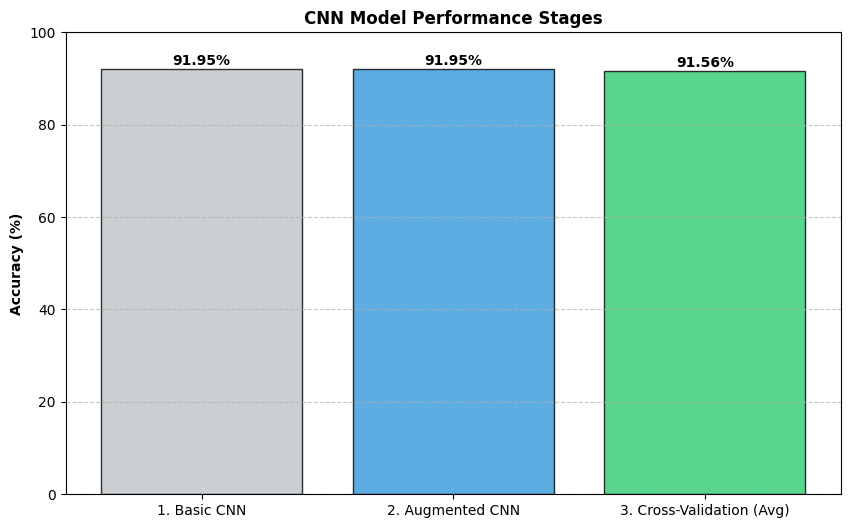

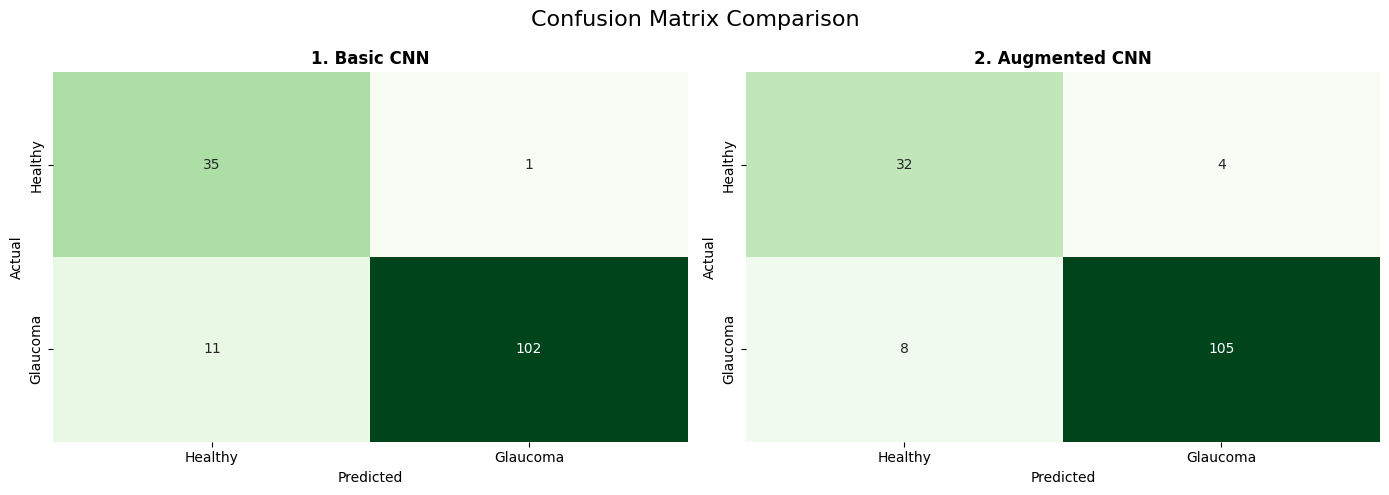

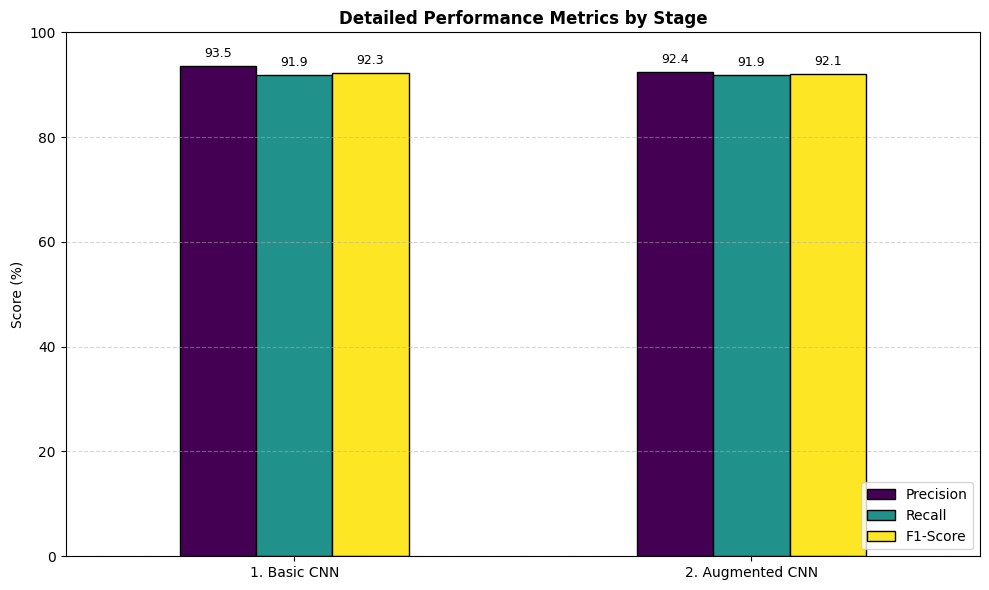


      FINAL RESULTS SUMMARY      
1. Basic CNN              : 91.95%
2. Augmented CNN          : 91.95%
3. Cross-Validation (Avg) : 91.56%


In [9]:
# --- CELL 6: COMPREHENSIVE VISUALIZATION ---

# 1. GRAPH 1: Accuracy Comparison Bar Chart
plt.figure(figsize=(10, 6))
names = list(results.keys())
values = [v * 100 for v in results.values()]
colors = ['#bdc3c7', '#3498db', '#2ecc71'] # Grey, Blue, Green

bars = plt.bar(names, values, color=colors, edgecolor='black', alpha=0.8)
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('CNN Model Performance Stages', fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', fontweight='bold', color='black')
plt.show()

# 2. GRAPH 2: Confusion Matrices Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
stages_to_plot = ["1. Basic CNN", "2. Augmented CNN"]

for i, stage_name in enumerate(stages_to_plot):
    y_true, y_pred = predictions_storage[stage_name]
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i], cbar=False,
                xticklabels=['Healthy', 'Glaucoma'],
                yticklabels=['Healthy', 'Glaucoma'])
    axes[i].set_title(stage_name, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.suptitle("Confusion Matrix Comparison", fontsize=16)
plt.tight_layout()
plt.show()

# 3. GRAPH 3: Detailed Metrics Comparison
metrics_data = []
for stage_name in stages_to_plot:
    y_true, y_pred = predictions_storage[stage_name]
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    metrics_data.append([p*100, r*100, f*100])

metrics_df = pd.DataFrame(metrics_data, columns=['Precision', 'Recall', 'F1-Score'], index=stages_to_plot)

metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Detailed Performance Metrics by Stage', fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("      FINAL RESULTS SUMMARY      ")
print("="*40)
for k, v in results.items():
    print(f"{k.ljust(25)} : {v*100:.2f}%")
print("="*40)

In [11]:
import os
import torch

DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"
cnn_path = os.path.join(DATASET_ROOT, 'cnn_best_model.pth')


torch.save(model_aug.state_dict(), cnn_path)

print(f"CNN Model saved successfully at: {cnn_path}")

CNN Model saved successfully at: G:\Thesis-Fall-25-26--G-606\data\cnn_best_model.pth


1. Previewing Augmented Data...


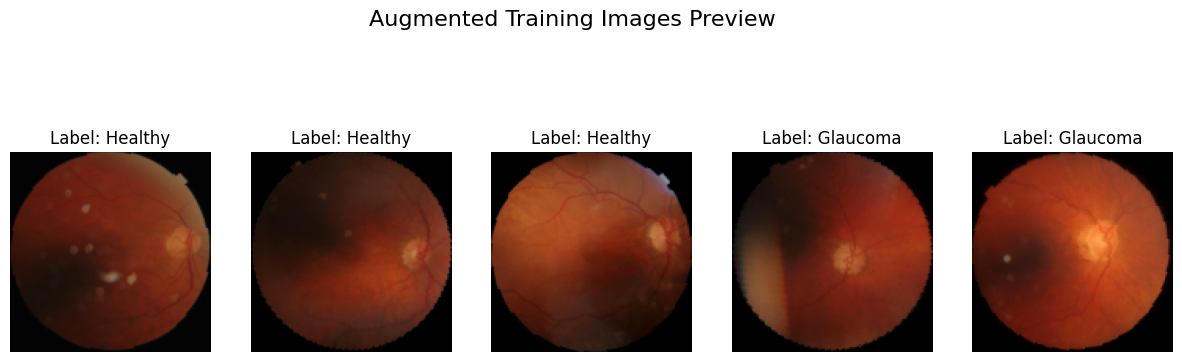


2. Showing Model Predictions...


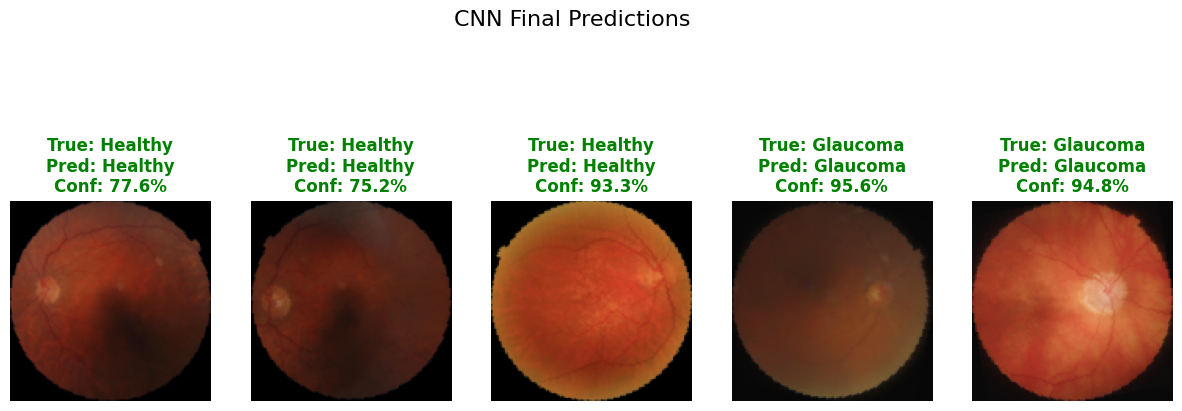

In [10]:
#  AUGMENTATION PREVIEW 
def show_augmented_preview(loader):
    images, labels = next(iter(loader)) 
    
    plt.figure(figsize=(15, 5))
    class_names = ['Healthy', 'Glaucoma']
    
    for i in range(min(5, len(images))):
        ax = plt.subplot(1, 5, i + 1)
        
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5) + 0.5 
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
        
    plt.suptitle("Augmented Training Images Preview", fontsize=16)
    plt.show()

#  FINAL PREDICTION WITH CONFIDENCE
def visualize_cnn_result(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1) 
        confidences, preds = torch.max(probs, 1)
        
    plt.figure(figsize=(15, 6))
    class_names = ['Healthy', 'Glaucoma']
    
    for i in range(min(5, len(images))):
        ax = plt.subplot(1, 5, i + 1)
        
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_lab = class_names[labels[i].item()]
        pred_lab = class_names[preds[i].item()]
        conf = confidences[i].item() * 100
        
        color = 'green' if true_lab == pred_lab else 'red'
        
        plt.title(f"True: {true_lab}\nPred: {pred_lab}\nConf: {conf:.1f}%", 
                  color=color, fontweight='bold')
        plt.axis("off")
        
    plt.suptitle("CNN Final Predictions", fontsize=16)
    plt.show()

print("1. Previewing Augmented Data...")
try:
    show_augmented_preview(train_loader_aug)
except NameError:
    print("Augmented loader not found, skipping preview.")

print("\n2. Showing Model Predictions...")

visualize_cnn_result(model_aug, test_loader_aug, device)